# **Import Data Set**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


# **Importing Tools & Libraries **

In [4]:
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# For splitting data if needed
from sklearn.model_selection import train_test_split


# **Quick EDA (quality & shape checks)**

In [5]:
# 0) paths
import os, glob, random, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

BASE = path  # from kagglehub
# try common layouts
candidates = [
    os.path.join(BASE, "Train"),
    os.path.join(BASE, "train"),
    os.path.join(BASE, "GTSRB", "Final_Training", "Images"),
]
train_root = next((p for p in candidates if os.path.isdir(p)), None)
assert train_root is not None, f"Couldn't find train folder under {BASE}. Found: {os.listdir(BASE)}"
print("Train root:", train_root)

# 1) gather (path, label) assuming subfolders per class (e.g., 00000..00042)
rows = []
for cls in sorted(os.listdir(train_root)):
    cls_dir = os.path.join(train_root, cls)
    if not os.path.isdir(cls_dir):
        continue
    for img_path in glob.glob(os.path.join(cls_dir, "*.*")):
        rows.append((img_path, cls))

df = pd.DataFrame(rows, columns=["path", "label"])
df.head(), df["label"].nunique(), len(df)


Train root: /kaggle/input/gtsrb-german-traffic-sign/Train


(                                                path label
 0  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
 1  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
 2  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
 3  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
 4  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0,
 43,
 39209)

# **Imbalance Check**

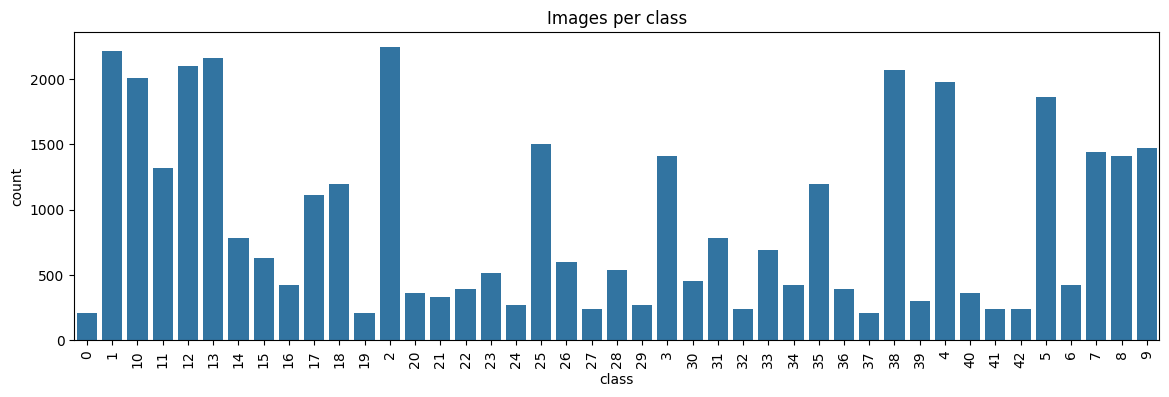

min/max/median per-class: 210 2250 600.0


In [6]:
# 2) counts per class
counts = df["label"].value_counts().sort_index()
plt.figure(figsize=(14,4))
sns.barplot(x=counts.index, y=counts.values)
plt.xticks(rotation=90)
plt.title("Images per class")
plt.ylabel("count"); plt.xlabel("class")
plt.show()

print("min/max/median per-class:", counts.min(), counts.max(), counts.median())


# **Show a grid of random samples**

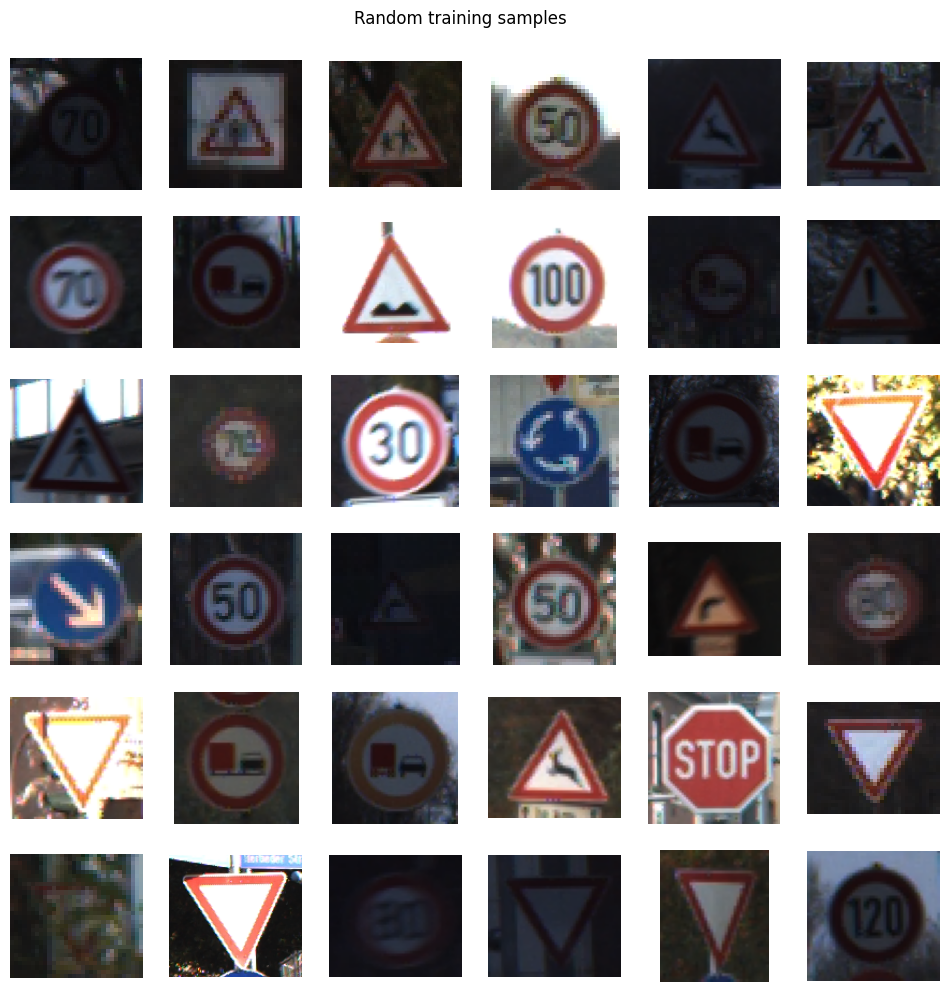

In [7]:

def show_grid(sample_df, n=25):
    picks = sample_df.sample(min(n, len(sample_df)), random_state=42)["path"].tolist()
    side = int(np.ceil(np.sqrt(len(picks))))
    plt.figure(figsize=(12,12))
    for i, p in enumerate(picks, 1):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        plt.subplot(side, side, i)
        plt.imshow(img); plt.axis("off")
    plt.suptitle("Random training samples", y=0.92)
    plt.show()

show_grid(df, n=36)


# **Image size / aspect ratio distribution**




avg WxH: 50.47 x 49.91
aspect ratio mean±std: 1.008 ± 0.07


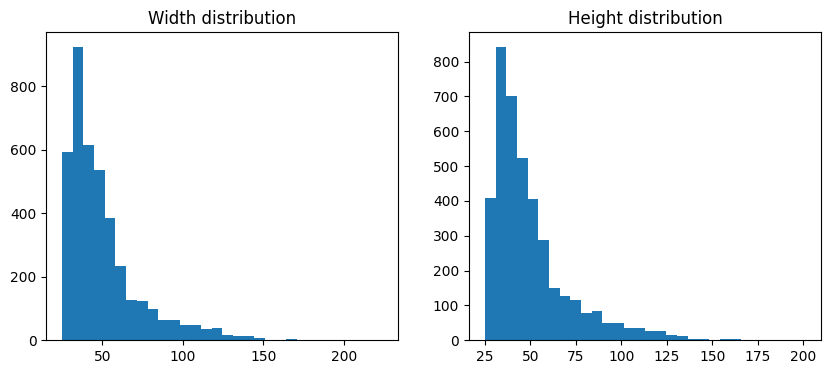

In [8]:

sizes = []
for p in df["path"].sample(min(4000, len(df)), random_state=42):
    img = cv2.imread(p)
    if img is None:
        continue
    h, w = img.shape[:2]
    sizes.append((w, h, w/h))
sizes = np.array(sizes)

print("avg WxH:", sizes[:,0].mean().round(2), "x", sizes[:,1].mean().round(2))
print("aspect ratio mean±std:", sizes[:,2].mean().round(3), "±", sizes[:,2].std().round(3))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(sizes[:,0], bins=30); plt.title("Width distribution")
plt.subplot(1,2,2); plt.hist(sizes[:,1], bins=30); plt.title("Height distribution")
plt.show()


# **Basic pixel stats + corrupt check (sampled)**

In [9]:

means, stds, bad = [], [], []
for p in df["path"].sample(min(3000, len(df)), random_state=42):
    img = cv2.imread(p)
    if img is None:
        bad.append(p); continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    means.append(img.mean()); stds.append(img.std())

print(f"sampled images: {len(means)}, corrupt: {len(bad)}")
print(f"pixel mean≈{np.mean(means):.3f}, std≈{np.mean(stds):.3f}")
if bad:
    print("first few corrupt paths:", bad[:5])


sampled images: 3000, corrupt: 0
pixel mean≈0.326, std≈0.174


# **Create train/val/test (80/10/10)**

In [10]:
import os, shutil, math, random, glob
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

random.seed(42)

# 0) source + destination roots
SRC_ROOT = train_root                           # e.g., "/kaggle/input/.../Train" (read-only)
DST_ROOT = "/content/gtsrb_folders"             # write here (Colab-friendly)
TRAIN_DIR = os.path.join(DST_ROOT, "train")
VAL_DIR   = os.path.join(DST_ROOT, "val")
TEST_DIR  = os.path.join(DST_ROOT, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

# 1) build dataframe of (path, label)
rows = []
for cls in sorted(os.listdir(SRC_ROOT)):
    cdir = os.path.join(SRC_ROOT, cls)
    if not os.path.isdir(cdir):
        continue
    for p in glob.glob(os.path.join(cdir, "*.*")):
        rows.append((p, cls))
df = pd.DataFrame(rows, columns=["path", "label"])

print("Total images:", len(df), " Classes:", df['label'].nunique())

# 2) stratified 80/10/10 split
train_df, temp_df = train_test_split(
    df, test_size=0.20, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

def _copy_to_split(split_df, split_dir):
    for cls in split_df["label"].unique():
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
    for p, cls in tqdm(split_df[["path", "label"]].itertuples(index=False), total=len(split_df)):
        dst = os.path.join(split_dir, cls, os.path.basename(p))
        if not os.path.exists(dst):
            shutil.copy2(p, dst)

_copy_to_split(train_df, TRAIN_DIR)
_copy_to_split(val_df,   VAL_DIR)
_copy_to_split(test_df,  TEST_DIR)

print("Done. Folder structure at:", DST_ROOT)


Total images: 39209  Classes: 43


100%|██████████| 3921/3921 [00:13<00:00, 280.89it/s]

Done. Folder structure at: /content/gtsrb_folders


# **Resize to a fixed shape (64×64).**

CNNs expect all inputs to be the same size.

In GTSRB, images vary a lot (some 25×25, others 200×200). If we feed them as-is, the model can’t batch them.

So we resize to a fixed shape, e.g. 64×64.
50 is okay, but powers of 2 (32, 64, 128) are often chosen because:

They align better with GPU tensor operations.

Pretrained models (like MobileNet, ResNet) are designed for 64, 96, 128, etc.

Going a bit larger (64) also preserves more detail from signs without making training too heavy.

👉 So 64×64 is a safe balance.

In [11]:
import tensorflow as tf

IMG_SIZE   = 64
BATCH_SIZE = 64
SEED       = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get class names before mapping and prefetching
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names
print("Classes:", num_classes, class_names[:10], "...")

# normalize to [0,1]
norm = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (norm(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: (norm(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x,y: (norm(x), y)).prefetch(tf.data.AUTOTUNE)

Found 31367 files belonging to 43 classes.
Found 3921 files belonging to 43 classes.
Found 3921 files belonging to 43 classes.
Classes: 43 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17'] ...


# **Handle Class Imbalance**

In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

labels = train_df["label"].astype(int).values
classes = np.unique(labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
class_weight


{0: 4.342054263565892,
 1: 0.41073486276974647,
 2: 0.40525839793281654,
 3: 0.6466889328715157,
 4: 0.460520906741837,
 5: 0.4902319329832458,
 6: 2.171027131782946,
 7: 0.6332162467700259,
 8: 0.6466889328715157,
 9: 0.6202934662236987,
 10: 0.4536474603725558,
 11: 0.6907813601127555,
 12: 0.43420542635658915,
 13: 0.4221441645133506,
 14: 1.169014609421586,
 15: 1.4473514211886305,
 16: 2.171027131782946,
 17: 0.8214697255394929,
 18: 0.759859496124031,
 19: 4.342054263565892,
 20: 2.5328649870801034,
 21: 2.763125440451022,
 22: 2.338029218843172,
 23: 1.787904696762426,
 24: 3.3771533161068046,
 25: 0.6078875968992248,
 26: 1.519718992248062,
 27: 3.799297480620155,
 28: 1.6885766580534023,
 29: 3.3771533161068046,
 30: 2.0262919896640827,
 31: 1.169014609421586,
 32: 3.799297480620155,
 33: 1.3238931329928671,
 34: 2.171027131782946,
 35: 0.759859496124031,
 36: 2.338029218843172,
 37: 4.342054263565892,
 38: 0.44049825862262665,
 39: 3.039437984496124,
 40: 2.5328649870801034,


# **Baseline CNN**

Blocks: (Conv→BN→ReLU)×2 → MaxPool → Dropout → repeat with 64 filters → 128 block → GAP → Dense(256) → Dropout → Softmax(43).

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

IMG_SIZE   = 64
# NUM_CLASSES = len(train_ds.class_names) # This was causing the error
NUM_CLASSES = num_classes # Use the variable defined in the previous cell

def make_baseline(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

model = make_baseline()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 184,779 (721.79 KB)

 Trainable params: 184,139 (719.29 KB)

 Non-trainable params: 640 (2.50 KB)

# **Training Setup**

Callbacks: EarlyStopping (patience 8, restore best), ReduceLROnPlateau (factor 0.5, patience 3).

GPU: T4 enabled in Colab.

Epochs: set to 50 but EarlyStopping stopped around ~40.

In [14]:
es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=8, restore_best_weights=True
)
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight,   # <-- use your weights here
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.1086 - loss: 4.5936 - val_accuracy: 0.1385 - val_loss: 3.2461 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.2325 - loss: 3.1802 - val_accuracy: 0.2540 - val_loss: 2.5704 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3366 - loss: 2.3879 - val_accuracy: 0.3542 - val_loss: 2.1714 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4594 - loss: 1.7944 - val_accuracy: 0.5216 - val_loss: 1.4519 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5927 - loss: 1.2621 - val_accuracy: 0.7034 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7231 - loss: 0.8097 - val_accuracy: 0.7745 - val_loss: 0.6936 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7814 - l

# **Test set accuracy**

In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")


Test accuracy: 0.9990  |  Test loss: 0.0063


# **Results**

In [19]:

import numpy as np, tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



y_true, y_pred = [], []
for x_batch, y_batch in test_ds:
    y_true.extend(tf.argmax(y_batch, axis=1).numpy())
    preds = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00       222
          10       1.00      1.00      1.00       201
          11       1.00      1.00      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
          17       1.00      1.00      1.00       111
          18       1.00      1.00      1.00       120
          19       1.00      1.00      1.00        21
           2       1.00      0.99      1.00       225
          20       1.00      1.00      1.00        36
          21       1.00      1.00      1.00        33
          22       1.00      1.00      1.00        39
          23       1.00      1.00      1.00        51
          24       1.00    

**Confusion matrix: clean diagonal (virtually no confusions).**

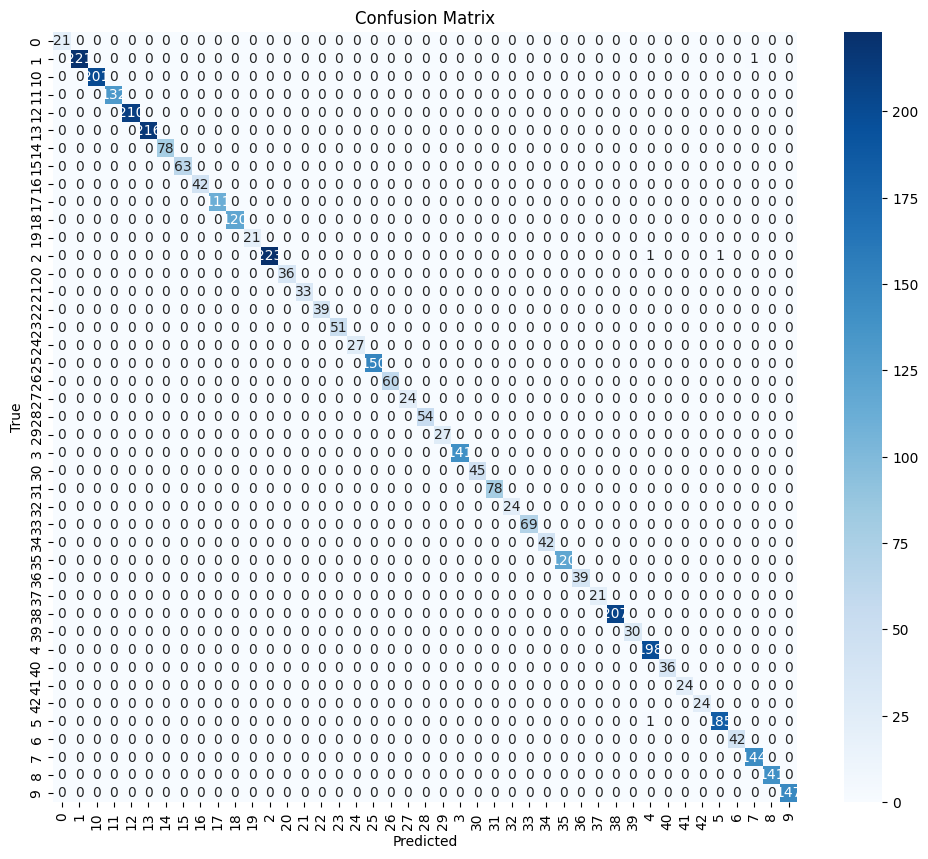

In [33]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i==j or cm[i,j]==0:
            continue
        pct = cm[i,j] / cm[i].sum()
        pairs.append((pct, int(cm[i,j]), i, j))
pairs.sort(reverse=True)

print("Top confusions (True → Pred):")
for k in range(min(10, len(pairs))):
    pct, cnt, i, j = pairs[k]
    print(f"{class_names[i]} → {class_names[j]}  |  {cnt} images  ({pct*100:.2f}%)")


Top confusions (True → Pred):
5 → 4  |  1 images  (0.54%)
1 → 7  |  1 images  (0.45%)
2 → 5  |  1 images  (0.44%)
2 → 4  |  1 images  (0.44%)


In [36]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_names)))
report_df = pd.DataFrame({
    "class": class_names,
    "support": sup,
    "precision": prec.round(3),
    "recall": rec.round(3),
    "f1": f1.round(3),
})
report_df = report_df.sort_values("support", ascending=False)
report_df.head(10)


,class,support,precision,recall,f1
12,2,225,1.000,0.991,0.996
1,1,222,1.000,0.995,0.998
5,13,216,1.000,1.000,1.000
4,12,210,1.000,1.000,1.000
32,38,207,1.000,1.000,1.000
2,10,201,1.000,1.000,1.000
34,4,198,0.990,1.000,0.995
38,5,186,0.995,0.995,0.995
18,25,150,1.000,1.000,1.000
42,9,147,1.000,1.000,1.000


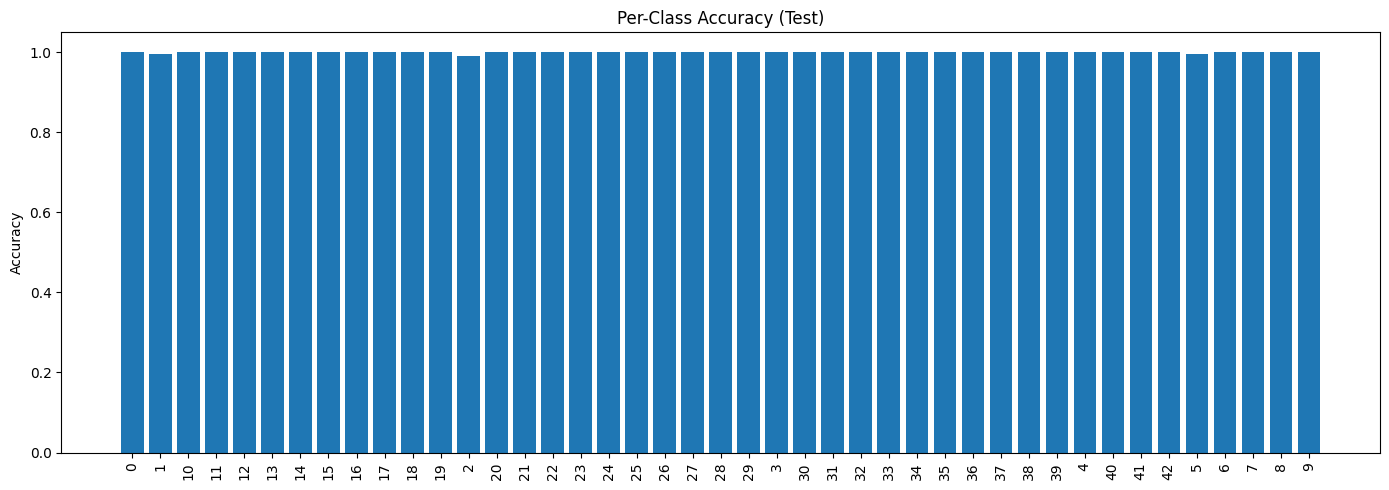

In [37]:
from sklearn.metrics import accuracy_score

per_class_acc = []
for i in range(len(class_names)):
    idx = np.where(y_true == i)[0]
    acc = accuracy_score(y_true[idx], y_pred[idx]) if len(idx) else 0.0
    per_class_acc.append(acc)

plt.figure(figsize=(14,5))
plt.bar(range(len(class_names)), per_class_acc)
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.ylim(0.0, 1.05)
plt.title("Per-Class Accuracy (Test)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


# **Save the model**

In [38]:
model.save("/content/gtsrb_cnn_baseline.h5")
print("Saved to /content/gtsrb_cnn_baseline.h5")


Saved to /content/gtsrb_cnn_baseline.h5
